In [2]:
# config
config = {
    "data_path": "../",
    "model": {
        "encoder_name": "timm-resnest26d",
        "loss_smooth": 1.0,
        "optimizer_params": {"lr": 0.001, "weight_decay": 0.0},
        "scheduler": {
            "name": "CosineAnnealingLR",
            "params": {
                "CosineAnnealingLR": {"T_max": 50, "eta_min": 1e-06, "last_epoch": -1},
                "ReduceLROnPlateau": {
                    "factor": 0.316,
                    "mode": "min",
                    "patience": 3,
                    "verbose": True,
                },
            },
        },
        "seg_model": "Unet",
    },
    "output_dir": "pytorchmodels",
    "progress_bar_refresh_rate": 500,
    "seed": 42,
    "train_bs": 128,
    "trainer": {
        "enable_progress_bar": True,
        "max_epochs": 15,
        "min_epochs": 8,
        "accelerator": "mps",
        "devices": 1,
    },
    "valid_bs": 128,
    "workers": 0,
    "device": "mps",
    "folds": {
        "n_splits": 4,
        "random_state": 42,
        "train_folds": [0, 1, 2, 3]
    }
}

import pandas as pd

train = pd.read_csv('data/single_turbine_data/train_reduced_unskewed_extra.csv')
test = pd.read_csv('data/single_turbine_data/test_reduced_unskewed_extra.csv')

label = ['1_Gear oil temperature (°C)']

X_train = train.drop(label, axis=1)
y_train = train[label]
X_test = test.drop(label, axis=1)
y_test = test[label]

# convert to datetime
X_train['# Date and time'] = pd.to_datetime(X_train['# Date and time'])
X_test['# Date and time'] = pd.to_datetime(X_test['# Date and time'])

# Setting the index
X_train.set_index('# Date and time', inplace=True)
X_test.set_index('# Date and time', inplace=True)

original_cols = ['1_Wind direction (°)',
       '1_Nacelle position (°)', '1_Power (kW)',
       '1_Front bearing temperature (°C)', '1_Rear bearing temperature (°C)',
       '1_Stator temperature 1 (°C)', '1_Nacelle ambient temperature (°C)',
       '1_Nacelle temperature (°C)', '1_Transformer temperature (°C)',
       '1_Generator bearing rear temperature (°C)',
       '1_Generator bearing front temperature (°C)', '1_Temp. top box (°C)',
       '1_Hub temperature (°C)', '1_Ambient temperature (converter) (°C)',
       '1_Rotor bearing temp (°C)', '1_Transformer cell temperature (°C)', '1_Generator RPM (RPM)']
extras = ['month_sin', 'month_cos', 'hour_sin', 'hour_cos', 
'curtailed', 
'offline',
]
leadsnlags = [
       '1_Wind direction (°)_lead6', 
       '1_Nacelle position (°)_lead3',
       '1_Power (kW)_lag6', 
       '1_Stator temperature 1 (°C)',
       '1_Stator temperature 1 (°C)_lag1',
       '1_Nacelle ambient temperature (°C)_lead6',
       '1_Transformer temperature (°C)_lead6',
       '1_Generator bearing rear temperature (°C)_lag1',
       '1_Temp. top box (°C)_lag1', 
       '1_Hub temperature (°C)_lead6',
       '1_Ambient temperature (converter) (°C)_lead6',
       '1_Transformer cell temperature (°C)_lead6',
       '1_Generator RPM (RPM)_lead6']

cols = original_cols + extras + leadsnlags
X_test = X_test[cols]
X_train = X_train[cols]

# scale the data
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
import lightning.pytorch as pl
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# Convert Pandas DataFrame to PyTorch Tensor
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=config['train_bs'], shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=config['valid_bs'], shuffle=True)

# Define Neural Network
class LightningModule(pl.LightningModule):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.config = config
        self.layer1 = nn.Linear(input_dim, input_dim*2)
        self.layer2 = nn.Linear(input_dim*2, input_dim*2)
        self.layer3 = nn.Linear(input_dim*2, output_dim)
        # self.relu = nn.ReLU()
        self.relu = nn.LeakyReLU(0.3)
        # self.dropout = nn.Dropout(p=0.2)
        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        # x = self.dropout(x)
        x = self.relu(self.layer2(x))
        # x = self.dropout(x)
        x = self.layer3(x)
        return x

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters())

        if self.config['model']["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config['model']["scheduler"]["params"][self.config['model']["scheduler"]["name"]],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config['model']["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config['model']["scheduler"]["params"][self.config['model']["scheduler"]["name"]],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=False, on_epoch=True, prog_bar=True)
        logs = {"train_loss": loss, "lr": lr}
        return {"loss": loss, "log": logs}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return {"val_loss": loss}



from lightning.pytorch.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="my_model")

trainer = pl.Trainer(
         logger=logger, 
         **config["trainer"]
    )
# Evaluate the model
from sklearn.metrics import mean_squared_error
from math import sqrt

def get_val_loss(features):
    X_train_sub = X_train_tensor[:, features]
    X_test_sub = X_test_tensor[:, features]
    
    train_dataset = TensorDataset(X_train_sub, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=config['train_bs'], shuffle=True)
    
    test_dataset = TensorDataset(X_test_sub, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=config['valid_bs'], shuffle=True)
    
    model = LightningModule(X_train_sub.shape[1], y_train.shape[1])
    trainer.fit(model, train_loader, test_loader)

    # Test the model
    model.eval()
    y_pred = model(X_test_sub)
    y_pred = y_pred.detach().numpy()

    return sqrt(mean_squared_error(y_test, y_pred))

best_features = list(range(X_train.shape[1]))  # Initially consider all features
best_val_loss = float('inf')

while len(best_features) > 10:  # Replace with your desired number
    worst_feature = None
    worst_feature_val_loss = float('inf')
    
    for feature_to_remove in best_features:
        current_features = [f for f in best_features if f != feature_to_remove]
        
        val_loss = get_val_loss(current_features)
        
        if val_loss < worst_feature_val_loss:
            worst_feature_val_loss = val_loss
            worst_feature = feature_to_remove
    
    if worst_feature_val_loss < best_val_loss:
        best_val_loss = worst_feature_val_loss
        best_features.remove(worst_feature)
        print(f"Removed feature index {worst_feature}, new best val_loss: {best_val_loss}")
    else:
        print("No improvement, stopping.")
        break


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type      | Params
-------------------------------------
0 | layer1 | Linear    | 2.5 K 
1 | layer2 | Linear    | 5.0 K 
2 | layer3 | Linear    | 71    
3 | relu   | LeakyReLU | 0     
4 | loss   | MSELoss   | 0     
-------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.030     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:622: UserWarning: Checkpoint directory tb_logs/my_model/version_52/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name   | Type      | Params
-------------------------------------
0 | layer1 | Linear    | 2.5 K 
1 | layer2 | Linear    | 5.0 K 
2 | layer3 | Linear    | 71    
3 | relu   | LeakyReLU | 0     
4 | loss   | MSELoss   | 0     
-------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.030     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Removed feature index 0, new best val_loss: 0.09483033923048169


Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Sanity Checking: 0it [00:00, ?it/s]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:483: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

No improvement, stopping.


In [6]:
best_val_loss

0.09483033923048169

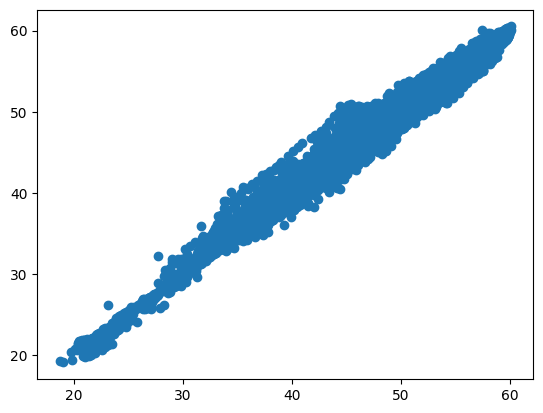

In [5]:
plt.scatter(y_test, y_pred)

In [27]:
# load the best checkpoint
state_dict = torch.load(f'{config["output_dir"]}/best_model.ckpt')
model = LightningModule(X_train.shape[1], y_train.shape[1])
model.load_state_dict(state_dict['state_dict'])

# save the model
torch.save(model.state_dict(), f'{config["output_dir"]}/nn483.pt')

In [26]:
# load the model and make predictions
state_dict = torch.load(f'{config["output_dir"]}/best_model.ckpt')
model = LightningModule(X_train.shape[1], y_train.shape[1])
model.load_state_dict(state_dict['state_dict'])
model.eval()
y_pred = model(X_test_tensor)
y_pred = y_pred.detach().numpy()
y_pred = scaler.inverse_transform(y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.483


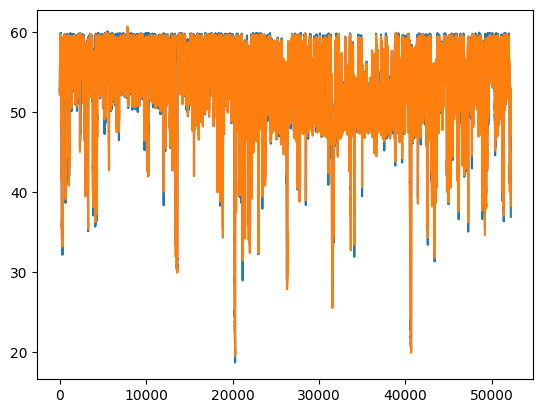

In [11]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')

In [22]:
class LightningModule(pl.LightningModule):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.config = config
        self.layer1 = nn.Linear(input_dim, input_dim*2)
        self.layer2 = nn.Linear(input_dim*2, input_dim*2)
        self.layer3 = nn.Linear(input_dim*2, output_dim)
        # self.relu = nn.ReLU()
        self.relu = nn.LeakyReLU(0.3)
        # self.dropout = nn.Dropout(p=0.2)
        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        # x = self.dropout(x)
        x = self.relu(self.layer2(x))
        # x = self.dropout(x)
        x = self.layer3(x)
        return x

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters())

        if self.config['model']["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config['model']["scheduler"]["params"][self.config['model']["scheduler"]["name"]],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config['model']["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config['model']["scheduler"]["params"][self.config['model']["scheduler"]["name"]],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=False, on_epoch=True, prog_bar=True)
        logs = {"train_loss": loss, "lr": lr}
        return {"loss": loss, "log": logs}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return {"val_loss": loss}